In [976]:
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import pickle

import warnings
warnings.filterwarnings(action='ignore')

In [977]:
# 항공 작업 경로 변환
# os.chdir("../file_csv/hotel")
# os.chdir("../../file_csv/hotel")

In [978]:
df = pd.read_csv('hotel_EDA_final.csv')
df.head()

,date,name,price,person,level,review_count,review_group,score,city,city_details,day,month,peak
0,2023-08-01,Premium 리벤시아 풀빌라&호텔,962500,4인,가족호텔,34.00000,500 미만,4.20000,제주시,한림읍,1,August,성수기
1,2023-08-01,갤러리 호텔 비앤비,52000,2인,비지니스,261.00000,500 미만,4.30000,제주시,연동,1,August,성수기
2,2023-08-01,골드원 호텔&스위트,591800,4인,4성급,147.00000,500 미만,4.80000,서귀포시,서호동,1,August,성수기
3,2023-08-01,골든튤립 제주성산호텔,123720,2인,비지니스,376.00000,500 미만,4.50000,서귀포시,성산읍,1,August,성수기
4,2023-08-01,그랜드 밀리언스 호텔 서귀포,50240,2인,비지니스,"1,326.00000",500 이상,4.70000,서귀포시,서호동,1,August,성수기


## 이상치 확인

### price

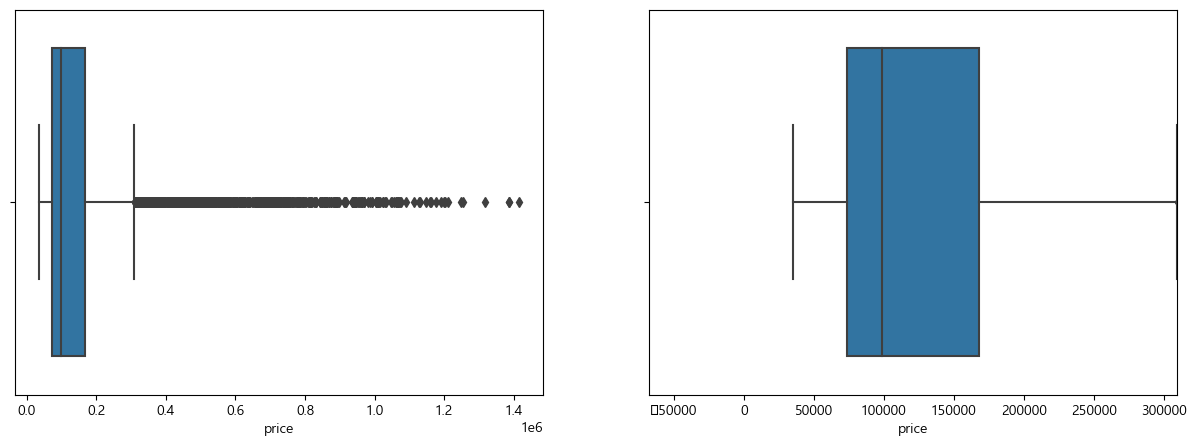

In [979]:
def limites(coluna):
    # 제1사분위수, 제3사분위수 정의
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    # 폭
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

# 박스플롯 생성 함수
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

diagrama_caixa(df['price'])

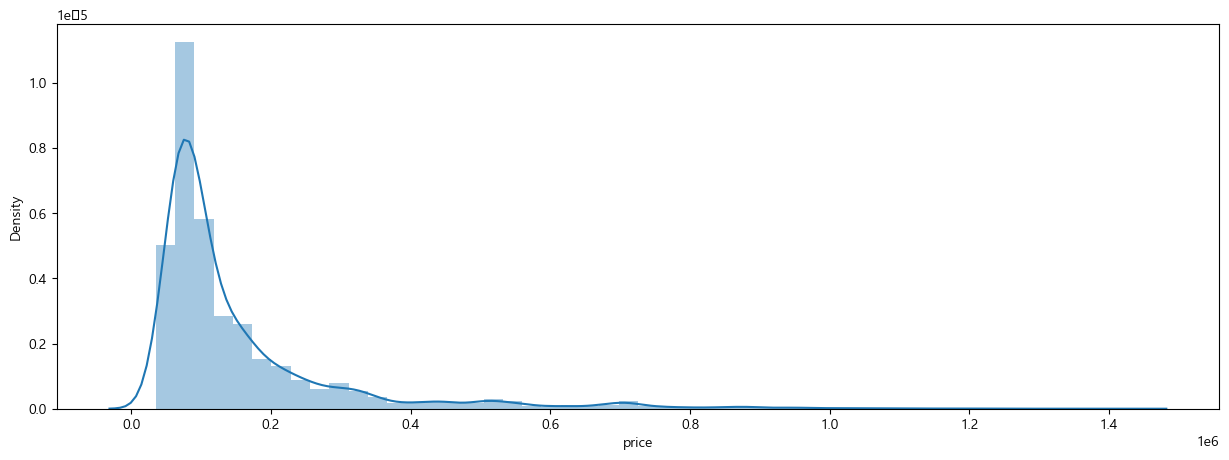

In [980]:
# 분포를 보기 위해 히스토그램 도표 생성
def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.distplot(coluna, hist=True)

histograma(df['price'])

In [981]:
df.describe()

,price,review_count,score,day
count,"15,264.00000","15,264.00000","15,264.00000","15,264.00000"
mean,"154,747.45656",471.59054,4.51017,15.74895
std,"151,478.71980",533.61237,0.27662,8.82573
min,"35,000.00000",4.00000,3.20000,1.00000
25%,"73,714.00000",95.00000,4.30000,8.00000
50%,"98,408.50000",268.00000,4.50000,16.00000
75%,"168,100.00000",670.00000,4.70000,23.00000
max,"1,415,700.00000","2,471.00000",5.00000,31.00000


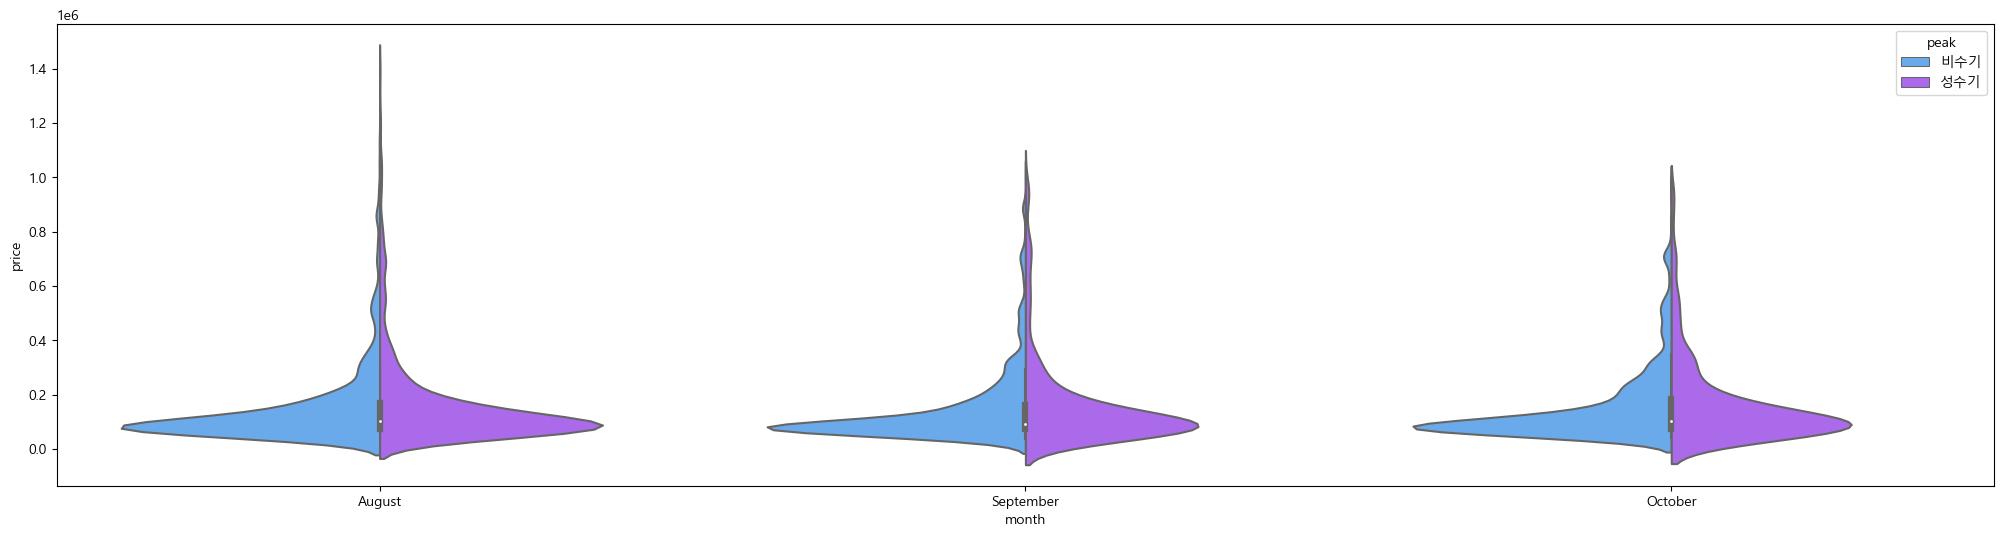

In [982]:
# 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 바이올린 플롯
plt.figure(figsize=(25,6))
ax = sns.violinplot(data=df, x='month', y='price',
                    hue='peak',
                    hue_order=['비수기', '성수기'],
                    palette='cool',
                    split=True)

In [983]:
# 분포가 고르지 못함
# box가 아닌 데이터들은 이상치로 간주 >> 데이터 삭제

# 이상치 자르는 함수 정의
def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    # 하한 및 상한 설정
    lim_inf, lim_sup = limites(df[nome_coluna])
    # 하한 위와 상한 이하의 값만 갖도록 기준을 필터링
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    # 몇 개의 데이터가 삭제되었는지 표시
    linhas_removidas = qtde_linhas - df.shape[0]
    return df,  linhas_removidas

df, linhas_removidas = excluir_outliers(df, 'price')
print('{} linhas removidas'.format(linhas_removidas))

# 인덱스 재정렬
df = df.reset_index(drop=True)

1513 linhas removidas


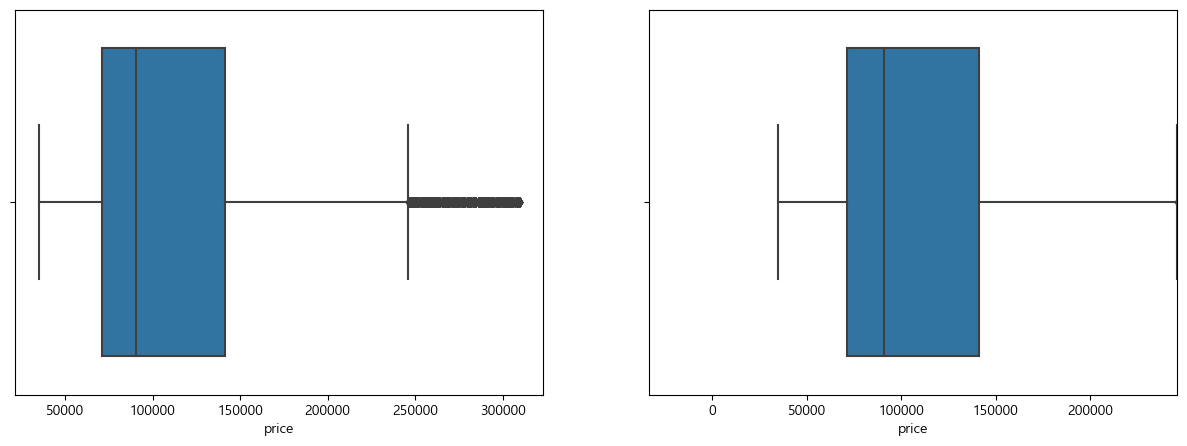

In [984]:
diagrama_caixa(df['price'])

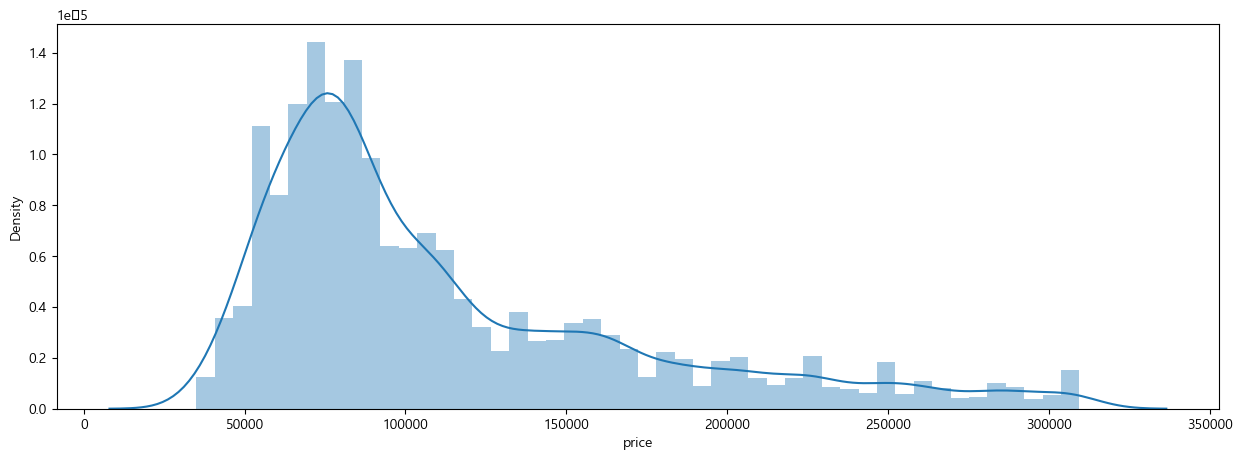

In [985]:
# 이상치를 제거한 데이터 분포
histograma(df['price'])

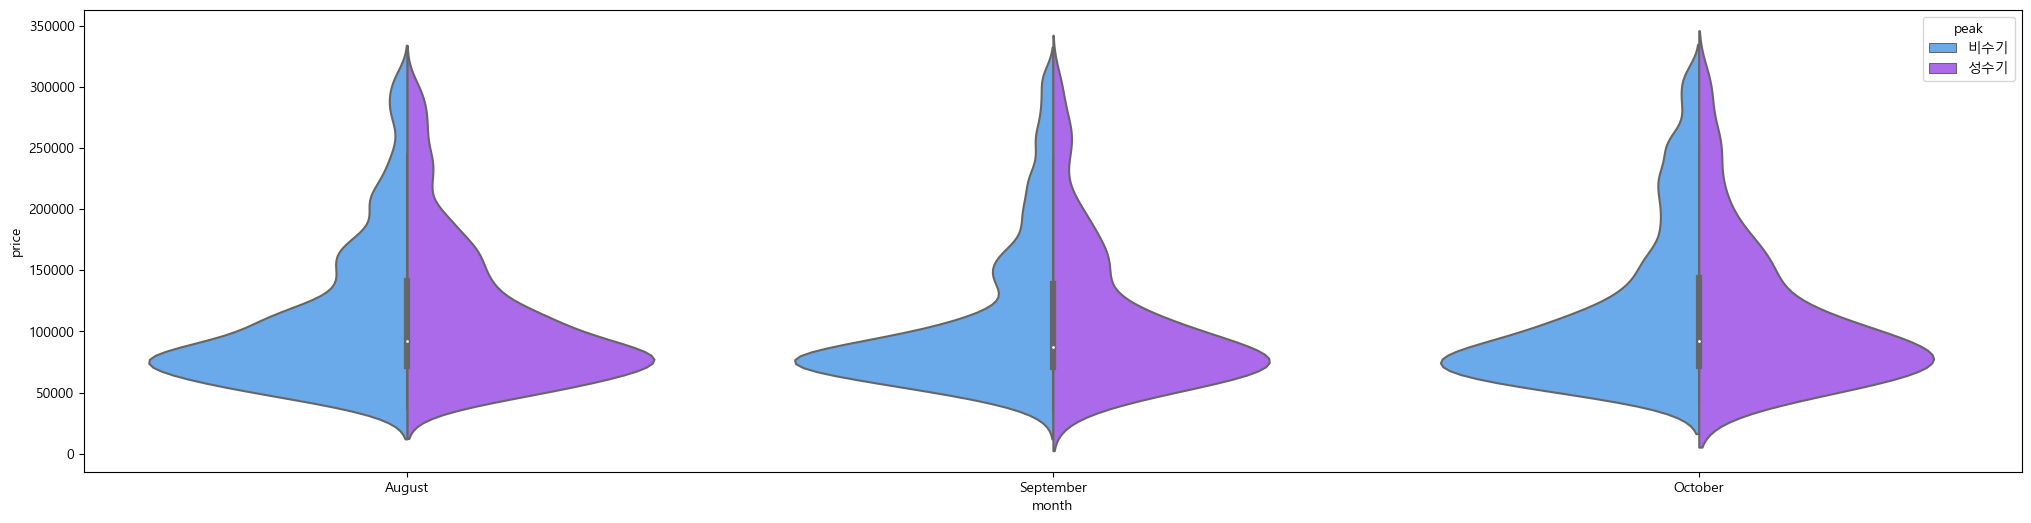

In [986]:
# 바이올린 플롯
plt.figure(figsize=(25,6))
ax = sns.violinplot(data=df, x='month', y='price',
                    hue='peak',
                    hue_order=['비수기', '성수기'],
                    palette='cool',
                    split=True)

In [987]:
# price의 [8월/9월/10월] 및 [평일/주말 및 공휴일]의 분포가 고름을 확인

### Score

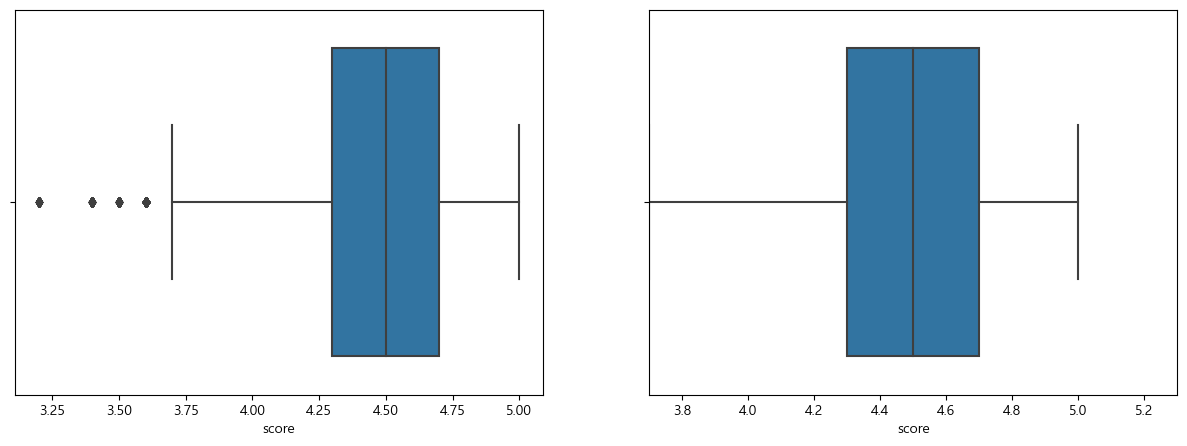

In [988]:
diagrama_caixa(df['score'])

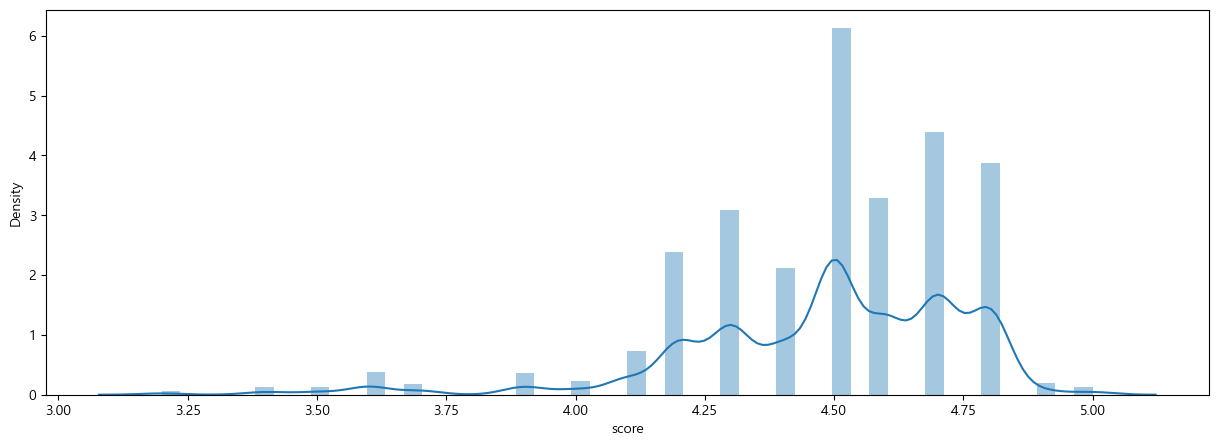

In [989]:
histograma(df['score'])

In [990]:
# 학습시키는 과정에서 Local Minima에 빠질 위험 존재 >> StandardScaler를 이용 여부 결정할 것!

## 데이터 분포 확인

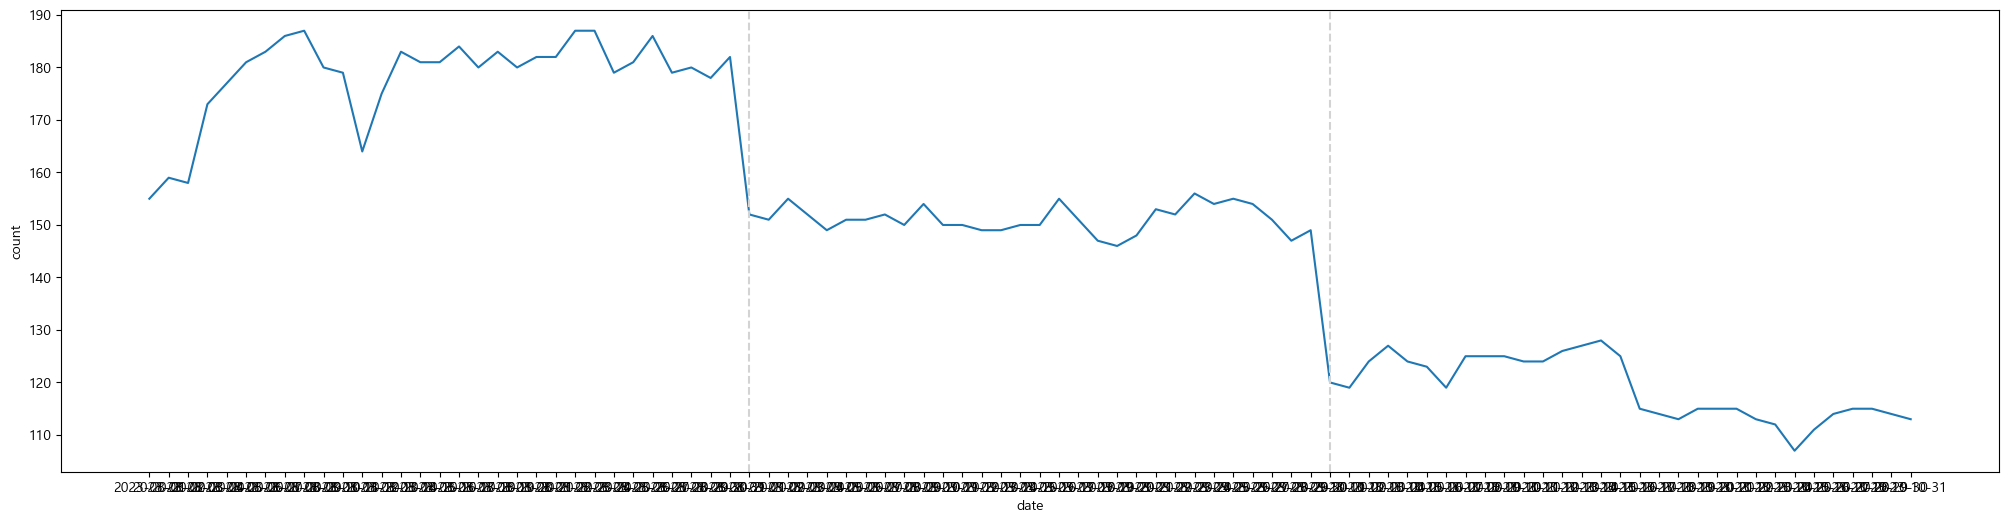

In [991]:
# 일자 별 숙소 개수 시각화

# 호텔명과 가격, 일자 중복 제거한 raw data
data_distribution_by_date = pd.DataFrame(data=df['date'].value_counts(sort=False)).reset_index()
data_distribution_by_date.columns = ['date', 'count']

plt.figure(figsize=(25,6))
ax = sns.lineplot(data=data_distribution_by_date, x='date', y='count')
plt.axvline(x='2023-09-01', color='lightgray', linestyle='--', label='2023-09-01')  # 9/1
plt.axvline(x='2023-10-01', color='lightgray', linestyle='--', label='2023-10-01')  # 10/1

In [992]:
# 데이터 분포가 8월 > 9월 > 10월 순으로 점차 감소

# >> 월별 숙박비 평균 표시 필요

In [993]:
Aug_mean = df.query('month == "August"')['price'].mean()
Sep_mean = df.query('month == "September"')['price'].mean()
Oct_mean = df.query('month == "October"')['price'].mean()

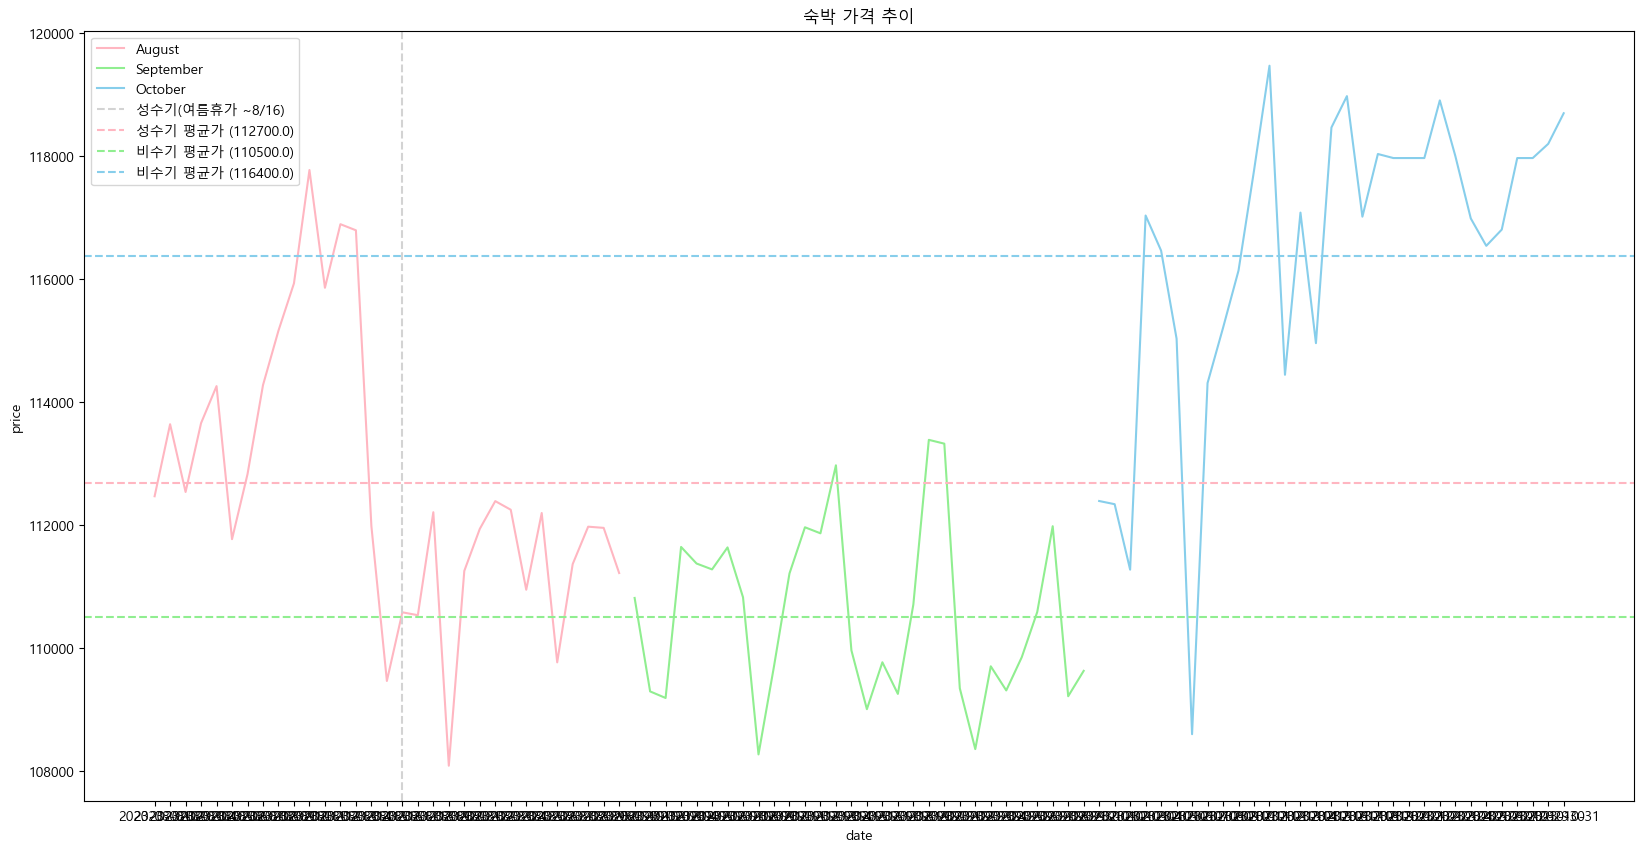

In [994]:
# 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

colors = ['lightpink', 'lightgreen', 'skyblue']

fig, axes = plt.subplots(1, figsize=(20, 10))
sns.lineplot(x='date', y='price', data=df, hue='month', ci=None, palette=colors).set_title('숙박 가격 추이')
plt.axvline(x='2023-08-17', color='lightgray', linestyle='--', label='성수기(여름휴가 ~8/16)')  # 성수기 (여름휴가 ~8/16)

plt.axhline(y=Aug_mean, color=colors[0], linestyle='--', label=f'성수기 평균가 ({Aug_mean.round(-2)})')  # 8월 평균가
plt.axhline(y=Sep_mean, color=colors[1], linestyle='--', label=f'비수기 평균가 ({Sep_mean.round(-2)})')  # 9월 평균가
plt.axhline(y=Oct_mean, color=colors[2], linestyle='--', label=f'비수기 평균가 ({Oct_mean.round(-2)})')  # 10월 평균가
plt.legend()

In [995]:
# 월별로 가격차가 있으며, 이는 데이터 양 때문으로 보임

## 인코딩

In [996]:
# 학습 시, 날짜는 불필요 but 주말여부는 필요 >> 주말(숙박 기준 금,토) 컬럼 생성
def is_weekends(date_str):
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    weekday_num = date_obj.weekday()   # weekday() : (0: 월요일, 6: 일요일)
    return '주말' if (weekday_num == 4) or (weekday_num == 5) else '평일'
df['weekends'] = df['date'].apply(is_weekends)
df

,date,name,price,person,level,review_count,review_group,score,city,city_details,day,month,peak,weekends
0,2023-08-01,갤러리 호텔 비앤비,52000,2인,비지니스,261.00000,500 미만,4.30000,제주시,연동,1,August,성수기,평일
1,2023-08-01,골든튤립 제주성산호텔,123720,2인,비지니스,376.00000,500 미만,4.50000,서귀포시,성산읍,1,August,성수기,평일
2,2023-08-01,그랜드 밀리언스 호텔 서귀포,50240,2인,비지니스,"1,326.00000",500 이상,4.70000,서귀포시,서호동,1,August,성수기,평일
3,2023-08-01,글로스터호텔제주,151200,2인,비지니스,897.00000,500 이상,4.70000,제주시,연동,1,August,성수기,평일
4,2023-08-01,까사로마 호텔,251000,4인,4성급,847.00000,500 이상,4.80000,서귀포시,서귀동,1,August,성수기,평일
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13746,2023-10-31,호텔 휴식 서귀포,53000,4인,3성급,563.00000,500 이상,4.60000,서귀포시,서귀동,31,October,비수기,평일
13747,2023-10-31,호텔위드시티,75825,4인,비지니스,186.00000,500 미만,4.70000,제주시,노형동,31,October,비수기,평일
13748,2023-10-31,호텔이디,64800,4인,비지니스,90.00000,500 미만,4.70000,서귀포시,남원읍,31,October,비수기,평일
13749,2023-10-31,화이트하우스 호텔,89500,4인,관광,275.00000,500 미만,4.20000,제주시,용담삼동,31,October,비수기,평일


In [997]:
# csv 파일 변환 >> 최종 데이터
df.to_csv("hotel_EDA_rrrrrrreal_final.csv", index=False, encoding="utf-8-sig", mode="w")

In [998]:
# date, day, review_counts 컬럼은 제거 (높은 카다날리티)
df = df.drop(['date', 'day', 'review_count'], axis=1)

df_origin = df.copy()
df_origin

,name,price,person,level,review_group,score,city,city_details,month,peak,weekends
0,갤러리 호텔 비앤비,52000,2인,비지니스,500 미만,4.30000,제주시,연동,August,성수기,평일
1,골든튤립 제주성산호텔,123720,2인,비지니스,500 미만,4.50000,서귀포시,성산읍,August,성수기,평일
2,그랜드 밀리언스 호텔 서귀포,50240,2인,비지니스,500 이상,4.70000,서귀포시,서호동,August,성수기,평일
3,글로스터호텔제주,151200,2인,비지니스,500 이상,4.70000,제주시,연동,August,성수기,평일
4,까사로마 호텔,251000,4인,4성급,500 이상,4.80000,서귀포시,서귀동,August,성수기,평일
...,...,...,...,...,...,...,...,...,...,...,...
13746,호텔 휴식 서귀포,53000,4인,3성급,500 이상,4.60000,서귀포시,서귀동,October,비수기,평일
13747,호텔위드시티,75825,4인,비지니스,500 미만,4.70000,제주시,노형동,October,비수기,평일
13748,호텔이디,64800,4인,비지니스,500 미만,4.70000,서귀포시,남원읍,October,비수기,평일
13749,화이트하우스 호텔,89500,4인,관광,500 미만,4.20000,제주시,용담삼동,October,비수기,평일


In [999]:
# 원하는 순서와 매핑 값 정의
person_mapping = {'2인': 0, '4인': 1}  # (4인 : 2인도 포함 / 2인 : 2인만)
level_mapping = {'비지니스': 0, '1성급': 1, '2성급': 2, '3성급': 3, '4성급': 4, '5성급': 5, '부티크': 6, '레지던스': 7, '관광': 8, '가족호텔': 9, '콘도': 10}
city_mapping = {'제주시': 0, '서귀포시': 1}
city_details_mapping = {'연동':0, '성산읍':1, '서호동':2, '서귀동':3, '구좌읍':4, '노형동':5, '조천읍':6, '이도이동':7,
                        '삼도이동':8, '표선면':9, '대정읍':10, '애월읍':11, '삼양이동':12, '색달동':13, '강정동':14,
                        '삼도일동':15, '법환동':16, '토평동':17, '서홍동':18, '건입동':19, '이호일동':20, '오라이동':21,
                        '용담일동':22, '한림읍':23, '용담이동':24, '용담삼동':25, '중문동':26, '호근동':27, '내도동':28,
                        '하예동':29, '남원읍':30, '오등동':31, '안덕면':32, '외도일동':33, '보목동':34, '상예동':35}
month_mapping = {'August': 8, 'September': 9, 'October': 10}
peak_mapping = {'비수기': 0, '성수기': 1}
weekends_mapping = {'평일': 0, '주말': 1}
review_group_mapping = {'500 미만': 0, '500 이상': 1}

In [1000]:
df['person'] = df['person'].map(person_mapping)
df['level'] = df['level'].map(level_mapping)
df['city'] = df['city'].map(city_mapping)
df['city_details'] = df['city_details'].map(city_details_mapping)
df['month'] = df['month'].map(month_mapping)
df['peak'] = df['peak'].map(peak_mapping)
df['weekends'] = df['weekends'].map(weekends_mapping)
df['review_group'] = df['review_group'].map(review_group_mapping)
df

,name,price,person,level,review_group,score,city,city_details,month,peak,weekends
0,갤러리 호텔 비앤비,52000,0,0,0,4.30000,0,0,8,1,0
1,골든튤립 제주성산호텔,123720,0,0,0,4.50000,1,1,8,1,0
2,그랜드 밀리언스 호텔 서귀포,50240,0,0,1,4.70000,1,2,8,1,0
3,글로스터호텔제주,151200,0,0,1,4.70000,0,0,8,1,0
4,까사로마 호텔,251000,1,4,1,4.80000,1,3,8,1,0
...,...,...,...,...,...,...,...,...,...,...,...
13746,호텔 휴식 서귀포,53000,1,3,1,4.60000,1,3,10,0,0
13747,호텔위드시티,75825,1,0,0,4.70000,0,5,10,0,0
13748,호텔이디,64800,1,0,0,4.70000,1,30,10,0,0
13749,화이트하우스 호텔,89500,1,8,0,4.20000,0,25,10,0,0


In [1001]:
# 레이블 인코딩을 적용할 컬럼들 선택
columns_to_encode = ["name", "person", "level", 'review_group', "city", 'city_details', 'month', "peak", "weekends"]

# 레이블 인코더 생성 및 적용
label_encoder = LabelEncoder()
for column in columns_to_encode:
    df_origin[column] = label_encoder.fit_transform(df_origin[column])
df_origin

,name,price,person,level,review_group,score,city,city_details,month,peak,weekends
0,1,52000,0,9,0,4.30000,1,20,0,1,1
1,3,123720,0,9,0,4.50000,0,17,0,1,1
2,5,50240,0,9,1,4.70000,0,15,0,1,1
3,7,151200,0,9,1,4.70000,1,20,0,1,1
4,8,251000,1,3,1,4.80000,0,14,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
13746,181,53000,1,2,1,4.60000,0,14,1,0,1
13747,185,75825,1,9,0,4.70000,1,5,1,0,1
13748,186,64800,1,9,0,4.70000,0,3,1,0,1
13749,187,89500,1,6,0,4.20000,1,24,1,0,1


## 히트맵

,name,price,person,level,review_group,score,city,city_details,month,peak,weekends
name,1.00000,-0.18736,-0.04539,0.09863,-0.05289,-0.03526,-0.02837,-0.05933,-0.01434,0.01126,0.00019
price,-0.18736,1.00000,0.05048,-0.20279,0.07430,0.31037,-0.02992,0.18793,-0.01358,0.00439,0.00537
person,-0.04539,0.05048,1.00000,0.00435,-0.01960,-0.11315,0.00872,0.01137,0.06367,-0.10491,0.00798
level,0.09863,-0.20279,0.00435,1.00000,-0.01481,-0.09056,-0.02623,-0.05534,-0.00854,0.01017,-0.00529
review_group,-0.05289,0.07430,-0.01960,-0.01481,1.00000,0.18999,-0.05191,-0.14040,0.02857,-0.01618,-0.00070
score,-0.03526,0.31037,-0.11315,-0.09056,0.18999,1.00000,-0.30788,-0.14166,0.05281,-0.04362,0.00688
city,-0.02837,-0.02992,0.00872,-0.02623,-0.05191,-0.30788,1.00000,0.21169,-0.02778,0.01991,-0.00326
city_details,-0.05933,0.18793,0.01137,-0.05534,-0.14040,-0.14166,0.21169,1.00000,0.00485,-0.00499,-0.00158
month,-0.01434,-0.01358,0.06367,-0.00854,0.02857,0.05281,-0.02778,0.00485,1.00000,-0.36849,-0.07046
peak,0.01126,0.00439,-0.10491,0.01017,-0.01618,-0.04362,0.01991,-0.00499,-0.36849,1.00000,0.02679


<Axes: >

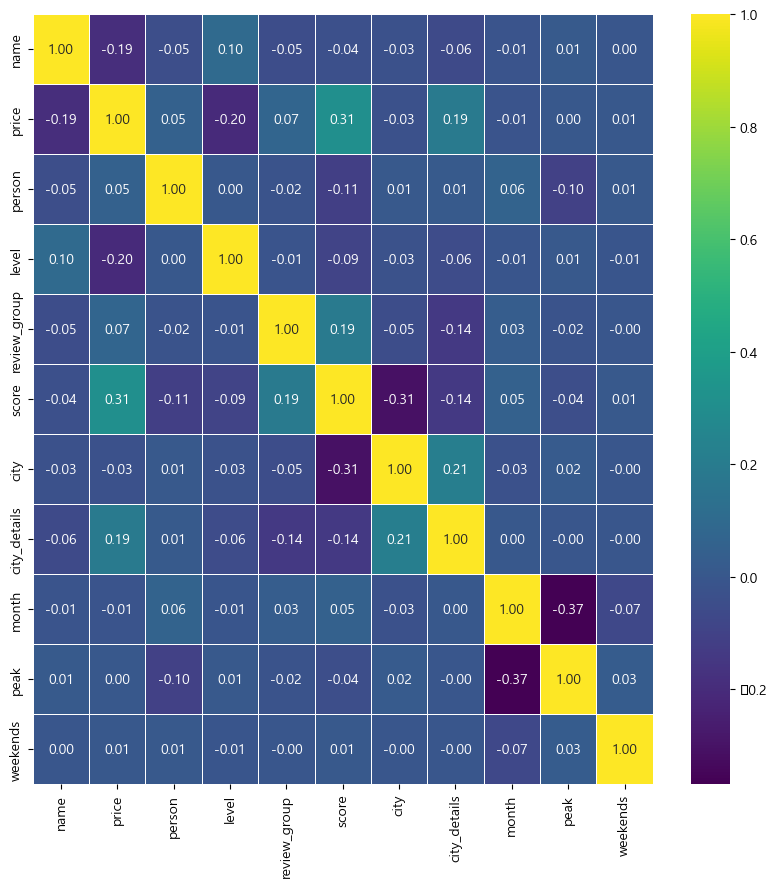

In [1002]:
# 전체
display(df_origin.corr())

plt.figure(figsize=(10,10))
sns.heatmap(df_origin.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='viridis')

In [1003]:
# price 와 상관관계가 높은 컬럼들

# name(0.19) : 카다날리티가 높음 >> 제거 예정 (name과 상관관계가 높은 컬럼들을 보기 위해 히트맵 그려봄)
# level(0.2) : 호텔의 규모, 기타시설 등으로 분류되는 경향이 있음 >> 가격에 영향을 미칠만한 요인임
# score(0.31) : 평점 또한 가격에 영향을 미칠만한 요인임
# city_details(0.19) : 공항과의 거리 및 위치에 따라 달라질 수 있음 but 이 또한 카다날리티가 높아 name과의 연관성을 확인해 볼 필요가 있음

In [1004]:
# name

# city_details와 name이 생각보다 낮은 연관성을 지님

In [1005]:
# city - score (0.31)
# >> ??

# month - peak (0.37)
# >> 월별 데이터 양이 달라서 월별 평균가가 점차 증가했었음 >> month 컬럼 삭제

# city - city_details
# >> 

## 데이터 분리

In [1006]:
# 훈련, 검증, 테스트 데이터 나누기

# Target 설정
target = 'price'

# X, y 데이터 분리
X = df.drop([target, 'name', 'month', 'score'], axis=1)
y = df.loc[:, target]

# 7:3으로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [1007]:
# XGBoost 모델 학습
xgb_model = xgb.XGBRegressor(random_state=22)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=22, ...)

In [1008]:
# xgbst 모델 예측
y_test_pred_xgb = xgb_model.predict(X_test)

In [1009]:
feature_importances = xgb_model.feature_importances_

importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

        Feature  Importance
1         level     0.46217
4  city_details     0.19308
3          city     0.15386
2  review_group     0.11560
0        person     0.05618
5          peak     0.01547
6      weekends     0.00363


In [1010]:
# 성능 평가 기준
def eval_models(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred).round(3)
    rmse = np.sqrt(mse).round(3)
    mae = mean_absolute_error(y_true, y_pred).round(3)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

In [1011]:
# XGBoost 성능평가
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)
comparison_xgb = pd.DataFrame(index=['mse', 'rmse', 'mae', 'r2'], columns=['Base', 'Train', 'Test'])
baseline = [y_train.mean()] * len(y_train)
comparison_xgb['Base'] = eval_models(y_train, baseline)
comparison_xgb['Train'] = eval_models(y_train, y_train_pred_xgb)
comparison_xgb['Test'] = eval_models(y_test, y_test_pred_xgb)

In [1012]:
pd.set_option('display.float_format', '{:,.5f}'.format)

In [1013]:
print("\nXGBoost 예측 성능:")
comparison_xgb


XGBoost 예측 성능:


,Base,Train,Test
mse,"3,708,835,447.03700","485,393,575.40800","539,708,024.86900"
rmse,"60,900.20900","22,031.64900","23,231.61700"
mae,"47,583.62000","12,892.37400","13,822.16600"
r2,0.00000,0.86913,0.84647


## 한계점

In [1014]:
# city_details의 카다날리티가 너무 높아서 city_details과 score(평점)으로 호텔이름을 예측하여 가격을 유추 >> 성능이 너무 좋음,,
# 하지만 호텔을 추천해주는 기준을 score(평점)으로 잡았기 때문에 삭제는 불가능

# 데이터 수에 비해 호텔이 201개밖에 되지 않아 그런 것 같다. (데이터 양 부족)

In [1015]:
# 데이터 분포를 보면 8, 9, 10월이 점차 감소한다.
# 호텔에서 예약기능을 한 달정도를 기준으로 잡아서 데이터가 점차 감소하는 것으로 예상

# 가격이 10월에 엄청 뛰는 것도 이 때문으로 예상됨

# >> 한 달 정도 전에 예약하면 예측률이 높을 것으로 예상

## 피클링

In [1016]:
# 저장할 경로 변경
os.chdir("../../model")

# 모델을 파일에 피클링하여 저장
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

# 저장된 피클 파일로부터 모델 불러오기
with open('xgb_model.pkl', 'rb') as file:
    loaded_xgb_model = pickle.load(file)

# 불러온 모델 사용 예시
# test_data = [[4, 5], [5, 6]]
# predictions = loaded_xgb_model.predict(test_data)
# print(predictions)